<a href="https://colab.research.google.com/github/cij1012/3-min-pytorch/blob/main/5.1%20Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [12]:
Epochs = 300
Batch_size = 128

In [13]:
# CIFAR10 데이터셋   32 * 32 * 3(RGB)의 이미지 6만개이상

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=Batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=Batch_size, shuffle=True)

Files already downloaded and verified


In [19]:

learning_rate = 0.0005
training_epochs = 50
batch_size = 256

In [21]:
cifar10_train = datasets.CIFAR10(root='cifar10/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

cifar10_test = datasets.CIFAR10(root='cifar10/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

Extracting cifar10/cifar-10-python.tar.gz to cifar10/
Files already downloaded and verified


In [22]:
data_loader = torch.utils.data.DataLoader(dataset=cifar10_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


In [14]:
# Gradient Vanishing

class SHALLOW_CNN(nn.Module):
  def __init__(self):
    super(SHALLOW_CNN, self).__init__()
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc = torch.nn.Linear(8 * 8 * 64, 10, bias=True)
    torch.nn.init.xavier_uniform_(self.fc.weight)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

In [15]:
class CNN(torch.nn.Module):

    def __init__(self,num_layers):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        self.layers = []
        for _ in range(num_layers):
            self.layers.append(torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
            self.layers.append(torch.nn.ReLU())
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.fc = torch.nn.Linear(5 * 5 * 128, 10)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layers(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [16]:
shallow_model = CNN(4).to(device)
deep_model = CNN(12).to(device)

In [28]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(shallow_model.parameters(), lr=learning_rate)

In [23]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))


총 배치의 수 : 195


In [29]:
shallow_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = shallow_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    shallow_costs.append(avg_cost)
    if epoch%10==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 2.30290389
[Epoch:   11] cost = 2.30262566
[Epoch:   21] cost = 2.30262542
[Epoch:   31] cost = 2.30262661
[Epoch:   41] cost = 2.30262136


In [32]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(deep_model.parameters(), lr=learning_rate)

In [33]:
deep_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = deep_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    deep_costs.append(avg_cost)
    if epoch%10==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.0833363086
[Epoch:   11] cost = 0.0597491898
[Epoch:   21] cost = 0.042409569
[Epoch:   31] cost = 0.0382402427
[Epoch:   41] cost = 0.037883427


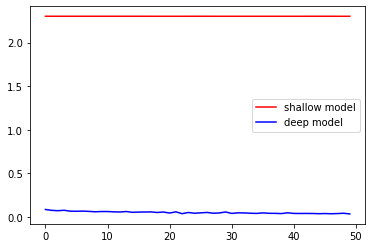

In [34]:
import matplotlib.pyplot as plt

plt.plot(shallow_costs, label = "shallow model",c='r')
plt.plot(deep_costs, label = "deep model",c='b')
plt.legend()
plt.show()